In [1]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import cv2 
from PIL import Image
import glob
from skimage import feature
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pickle
import pywt
import copy


import warnings
warnings.filterwarnings('ignore')

<h2>あやめの分類<h2>

In [2]:
iris = load_iris()
iris_target_data = pd.DataFrame(iris.target, columns=['Species'])
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)

X_train, X_test, Y_train, Y_test = train_test_split(iris_df, iris_target_data)

In [3]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, Y_train)

KNeighborsClassifier(n_neighbors=1)

In [4]:
Y_pred = knn.predict(X_test)
print(metrics.accuracy_score(Y_test, Y_pred))

1.0


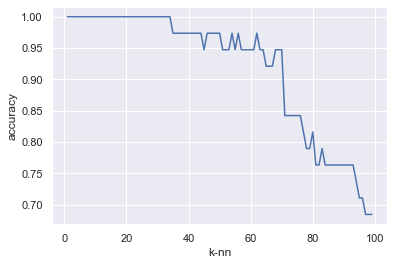

In [5]:
accuracy_list = []
sns.set()
k_range = range(1, 100)
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    accuracy_list.append(metrics.accuracy_score(Y_test, Y_pred))

figure = plt.figure()
ax = figure.add_subplot(111)
ax.plot(k_range, accuracy_list)
ax.set_xlabel('k-nn')
ax.set_ylabel('accuracy')
plt.show()

<h2>画像特徴量の分類<h2>

In [16]:
def burst_point(img):
    width, height = img.shape
    q2_x = int(width/2)
    q2_y = int(height/2)
    q1_x = int(q2_x/2)
    q1_y = int(q2_y/2)
    q3_x = int(q2_x+q1_x)
    q3_y = int(q2_y+q1_y)
    b_x = 16
    b_y = 16

    x_axis = [q1_x, q1_x, q3_x]
    y_axis = [q1_y, q2_y, q3_y]

    features_list = []
    for x_q in x_axis:
        for y_q in y_axis:
            cut_img = img[x_q-b_x:x_q+b_x, y_q-b_y:y_q+b_y]
            features, hog_img = feature.hog(cut_img, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1), visualize=True, multichannel=False)
            features_list.append(features)
    return features_list


def burst_feature_point(paths, mode):
    mode_list = ['train', 'test']
    if mode not in mode_list:
        raise Exception('Error!')
    train_feature = []
    hog_list = []
    name_list = []
    X_train = []
    for path in paths:
        
        # y_trainの作成
        slash_index = path.find('/')
        zoom_index = path.find('_zoom')
        name_list.append(path[slash_index+1:zoom_index])
        
        # 特徴点の場所をカット
        # 特徴量を作成
        img = cv2.imread(path, 0)
        width, height = img.shape
        q2_x = int(width/2)
        q2_y = int(height/2)
        q1_x = int(q2_x/2)
        q1_y = int(q2_y/2)
        q3_x = int(q2_x+q1_x)
        q3_y = int(q2_y+q1_y)
        b_x = 16
        b_y = 16

        x_axis = [q1_x, q1_x, q3_x]
        y_axis = [q1_y, q2_y, q3_y]

        cut_img_list = []
        features_list = []
        hog_img_list = []
        for x_q in x_axis:
            for y_q in y_axis:
                cut_img = img[x_q-b_x:x_q+b_x, y_q-b_y:y_q+b_y]
                features, hog_img = feature.hog(cut_img, orientations=8, pixels_per_cell=(8, 8),
                                                cells_per_block=(1, 1), visualize=True, multichannel=False)
                features_list.append(features)
                hog_img_list.append(hog_img)

# バウンディングボックスの場所の可視化
#         for x_q in x_axis:
#             for y_q in y_axis: 
#                 x1 = x_q-16
#                 x2 = x_q+16
#                 y1 = y_q-16
#                 y2 = y_q+16
#                 cv2.rectangle(img, (y1, x1), (y2, x2), color=(0, 255, 0), thickness=2)
#         save_path = 'boundingbox' + path[path.find('/'):]
#         cv2.imwrite(save_path, img)
        
        train_feature.append(features_list)
        hog_list.append(hog_img_list)
        
# 入力毎に特徴量を1次元に格納
    for col_feature in train_feature:
        data = np.array([])
        data = np.append(data, col_feature)
        X_train.append(data)
    X_train = np.array(X_train)    
    
    if mode == 'train':
        y_dict = {}
        le = LabelEncoder()
        y_train = le.fit_transform(name_list)
        decoded = le.inverse_transform(y_train)

        for name, name_id in zip(decoded, y_train):
            y_dict[name_id] = name
        return X_train, y_train, y_dict, hog_list
    else:
        return X_train

In [14]:
train_path = glob.glob('image_folder/*zoom*')
test_path = glob.glob('test_image/*')

In [15]:
X_train, y_train, y_dict, hog_list = burst_feature_point(train_path, 'train')
X_test = burst_feature_point(test_path, 'test')

In [17]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [18]:
y_pred = knn.predict(X_test)
for index in y_pred:
    print(y_dict[index])

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [29]:
test_path

['test_image/ume_test.png',
 'test_image/allegra_test.png',
 'test_image/panE_test.png',
 'test_image/dog_test.png',
 'test_image/konbu_test.png']

In [28]:
# filename = 'kNN_model_featurepoint.sav'
# pickle.dump(knn, open(filename, 'wb'))

<h2>ウェーブレットの特徴量<h2>

In [5]:
def image_normalization(src_img):
    """
    白飛び防止のための正規化処理
    cv2.imshowでwavelet変換された画像を表示するときに必要（大きい値を持つ画像の時だけ）
    """
    norm_img = (src_img - np.min(src_img)) / (np.max(src_img) - np.min(src_img))
    return norm_img

def merge_images(cA, cH_V_D):
    """numpy.array を４つ(左上、(右上、左下、右下))連結させる"""
    cH, cV, cD = cH_V_D
    cH = image_normalization(cH) # 外してもok
    cV = image_normalization(cV) # 外してもok
    cD = image_normalization(cD) # 外してもok
    cA = cA[0:cH.shape[0], 0:cV.shape[1]] # 元画像が2の累乗でない場合、端数ができることがあるので、サイズを合わせる。小さい方に合わせます。
    return np.vstack((np.hstack((cA,cH)), np.hstack((cV, cD)))) # 左上、右上、左下、右下、で画素をくっつける

def coeffs_visualization(cof):
    norm_cof0 = cof[0]
    norm_cof0 = image_normalization(norm_cof0) # 外してもok
    merge = norm_cof0
    for i in range(1, len(cof)):
        merge = merge_images(merge, cof[i])# ４つの画像を合わせていく
    plt.gray()
    plt.imshow(merge)

def wavelet_transform_for_image(src_image, level, M_WAVELET="db1", mode="sym"):
    data = src_image.astype(np.float64)
    coeffs = pywt.wavedec2(data, M_WAVELET, level=level, mode=mode)
    return coeffs

In [7]:
def burst_wave(img, wavelet_list, level, IMAGE_WIDTH=640, IMAGE_HEIGHT=480, M_WAVELET="db1", mode="sym"):
    img = cv2.resize(img, (IMAGE_WIDTH, IMAGE_HEIGHT))
    data = img.astype(np.float64)
    coeffs = pywt.wavedec2(data, M_WAVELET, level=level, mode=mode)

    wavelet_data = np.array([])
    for i, data in enumerate(coeffs):
        data = np.ravel(data)
        wavelet_data = np.append(wavelet_data, data)
    wavelet_list.append(wavelet_data)
    
    return wavelet_list
    
    
def burst_wavelet(paths, mode):
    mode_list = ['train', 'test']
    if mode not in mode_list:
        raise Exception('Error!')
        
    LEVEL = 5
    IMAGE_WIDTH = 640
    IMAGE_HEIGHT = 480
    MOTHER_WAVELET = "db1"
    wavelet_list = []
    name_list = []
    
    
    for path in paths:
        
#         slash_index = path.find('/')
#         zoom_index = path.find('_zoom')
#         name_list.append(path[slash_index+1:zoom_index])
        slash_index = path.find('/')
        dot_index = path.find('.')
        name_list.append(path[slash_index+1:dot_index])
    
        
        im = cv2.imread(path)
        img_gray = cv2.imread(path, 0)
        h, w = img_gray.shape
#         x_padding = IMAGE_WIDTH - w
#         y_padding = IMAGE_HEIGHT - h
#         img_gray = cv2.copyMakeBorder(img_gray, 0, y_padding, 0, x_padding, cv2.BORDER_CONSTANT, (0,0,0))
        img_resize = cv2.resize(img_gray, (IMAGE_WIDTH, IMAGE_HEIGHT))
        coeffs_gray = wavelet_transform_for_image(img_resize, LEVEL, M_WAVELET=MOTHER_WAVELET)
        
        wavelet_data = np.array([])
        for i, data in enumerate(coeffs_gray):
            data = np.ravel(data)
            wavelet_data = np.append(wavelet_data, data)
            
        wavelet_list.append(wavelet_data)
    X_train = np.array(wavelet_list)
    
    if mode == 'train':
        y_dict = {}
        le = LabelEncoder()
        y_train = le.fit_transform(name_list)
        decoded = le.inverse_transform(y_train)

        for name, name_id in zip(decoded, y_train):
            y_dict[name_id] = name
        return X_train, y_train, y_dict
    else:
        return X_train

In [37]:
train_path = glob.glob('box_train/*')
test_path = glob.glob('box_test/*')

In [38]:
X_train, y_train, y_dict = burst_wavelet(train_path, 'train')
X_test = burst_wavelet(test_path, 'test')

In [39]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [40]:
y_pred = knn.predict(X_test)
for index in y_pred:
    print(y_dict[index])

realsense
allegra
dog
iris


In [41]:
test_path

['box_test/realsense.png',
 'box_test/allegra.png',
 'box_test/dog.png',
 'box_test/iris.png']

<h2>画像特徴とウェーブレット係数の特徴量<h2>

In [102]:
def burst_features(paths, mode):
    LEVEL = 2
    IMAGE_WIDTH = 640
    IMAGE_HEIGHT = 480
    MOTHER_WAVELET = "db1"
    result_feature = []
    name_list = []
    train_point = []
    train_wave = []
    X_train = []
    burst_waves = []
    
    mode_list = ['train', 'test']
    if mode not in mode_list:
        raise Exception('Error!')
        
    for path in paths:
        
        # y_trainの作成
        slash_index = path.find('/')
        zoom_index = path.find('_zoom')
        for _ in range(4):
            name_list.append(path[slash_index+1:zoom_index])
        
        # 特徴点の場所をカット
        # 特徴量を作成
        img = cv2.imread(path, 0)
        img_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
        img_180 = cv2.rotate(img, cv2.ROTATE_180)
        img_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

        for im in [img, img_90, img_180, img_270]:
            burst_points = burst_point(im)
            burst_waves = burst_wave(img, burst_waves, LEVEL)
            result_feature.append(burst_points)

        
# 入力毎に特徴量を1次元に格納
    for col_feature in result_feature:
        data = np.array([])
        data = np.append(data, col_feature)
        train_point.append(data)
    train_point = np.array(train_point)
    
    train_wave = np.array(burst_waves)
    print(train_wave.shape)
    print(train_point.shape)
    X_train = np.concatenate((train_point, train_wave), axis=1)
    
    
    if mode == 'train':
        y_dict = {}
        le = LabelEncoder()
        y_train = le.fit_transform(name_list)
        decoded = le.inverse_transform(y_train)

        for name, name_id in zip(decoded, y_train):
            y_dict[name_id] = name
        return X_train, y_train, y_dict
    else:
        return X_train

In [103]:
train_path = glob.glob('image_folder/*zoom*')
test_path = glob.glob('test_image/*')

In [104]:
X_train, y_train, y_dict = burst_features(train_path, 'train')
X_test = burst_features(test_path, 'test')

(48, 307200)
(48, 1152)
(20, 307200)
(20, 1152)


In [105]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [106]:
y_pred = knn.predict(X_test)
for index in y_pred:
    print(y_dict[index])

onigiriB
onigiriB
onigiriB
onigiriB
boxA
boxA
boxA
boxA
panE
panE
panE
panE
boxB
boxB
boxB
boxB
onigiriB
onigiriB
onigiriB
onigiriB


In [107]:
y_pred

array([3, 3, 3, 3, 0, 0, 0, 0, 9, 9, 9, 9, 1, 1, 1, 1, 3, 3, 3, 3])

In [24]:
for path in test_path:
    print(path)

test_image/ume_test.png
test_image/allegra_test.png
test_image/panE_test.png
test_image/dog_test.png
test_image/konbu_test.png


## tkinterでの特徴量作成

In [3]:
def detect_contour(image):
    obj_dict = {}
    retval, bw = cv2.threshold(image, 50, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(bw, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    detect_count = 0

    for i in range(0, len(contours)):
        area = cv2.contourArea(contours[i])
        
        if area < 1e2 or 1e5 < area:
            continue
            
        if len(contours[i]) > 0:
            rect = contours[i]
            x, y, w, h = cv2.boundingRect(rect)
            
            angle_data = cv2.minAreaRect(contours[i])
            angle = angle_data[2]
            point = [y, y+h, x, x+w, angle]
            w_h = w + h
            obj_dict[w_h] = point 
    return obj_dict[max(obj_dict)]

In [40]:
def burst_features(depth_image, color_image, name):
    LEVEL = 2
    IMAGE_WIDTH = 640
    IMAGE_HEIGHT = 480
    MOTHER_WAVELET = "db1"
    result_feature = []
    name_list = []
    train_point = []
    train_wave = []
    X_train = []
    burst_waves = []
    
    image_list = []
    depth_copy = copy.deepcopy(depth_image)
    for col in depth_image:
        for one in col:
            if one > 1000:
                image_list.append(0)
            else:
                image_list.append(one)

    for y, col in enumerate(depth_image):
        for x, pixel in enumerate(col):
            if pixel > 0 and pixel < 375:
                depth_image[y][x] = 255
            else:
                depth_image[y][x] = 0
    image = np.array(depth_image, dtype=np.uint8)

    y1, y2, x1, x2, angle = detect_contour(image)
    color_cut = color_image[y1:y2, x1:x2]

    # 特徴点の場所をカット
    # 特徴量を作成
    img = cv2.cvtColor(color_cut, cv2.COLOR_BGR2GRAY)
    img_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
    img_180 = cv2.rotate(img, cv2.ROTATE_180)
    img_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

    for im in [img, img_90, img_180, img_270]:
        burst_points = burst_point(im)
        burst_waves = burst_wave(img, burst_waves, LEVEL)
        result_feature.append(burst_points)

        
# 入力毎に特徴量を1次元に格納
    for col_feature in result_feature:
        data = np.array([])
        data = np.append(data, col_feature)
        train_point.append(data)
    train_point = np.array(train_point)
    
    train_wave = np.array(burst_waves)
    X_train = np.concatenate((train_point, train_wave), axis=1)
    df = pd.DataFrame(X_train)
    df['y'] = name
    
    return df

In [41]:
depth = cv2.imread('depth_0.jpg', 0)
color = cv2.imread('color_0.jpg')

In [77]:
df = burst_features(depth, color, 'dog')

In [79]:
df

,0,1,2,3,4,5,6,7,8,9,...,308343,308344,308345,308346,308347,308348,308349,308350,308351,y
0,0.703884,0.057338,0.034081,0.000000,0.023342,0.000000,0.064045,0.703884,0.706202,0.025771,...,0.0,0.5,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,dog
1,0.512064,0.000000,0.461921,0.000000,0.512064,0.000000,0.512064,0.000000,0.556931,0.000000,...,0.0,0.5,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,dog
2,0.513742,0.422096,0.513742,0.000000,0.471918,0.000000,0.266957,0.000000,0.442496,0.631153,...,0.0,0.5,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,dog
3,0.431395,0.188971,0.431395,0.132961,0.431395,0.126892,0.431395,0.431395,0.418296,0.187962,...,0.0,0.5,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,dog


In [80]:
columns = df['y']
df.drop(['y'],axis=1,  inplace=True)
df = df.T
df.columns = columns

In [81]:
df

y,dog,dog,dog,dog
0,0.703884,0.512064,0.513742,0.431395
1,0.057338,0.000000,0.422096,0.188971
2,0.034081,0.461921,0.513742,0.431395
3,0.000000,0.000000,0.000000,0.132961
4,0.023342,0.512064,0.471918,0.431395
...,...,...,...,...
308347,0.000000,0.000000,0.000000,0.000000
308348,-0.500000,-0.500000,-0.500000,-0.500000
308349,0.000000,0.000000,0.000000,0.000000
308350,0.000000,0.000000,0.000000,0.000000


In [30]:
#df.drop(index=[0, 1, 2, 3], inplace=True)

In [56]:
df.to_csv('base.csv', index=False)

In [57]:
df_base = pd.read_csv('base.csv')

In [73]:
df_con = pd.concat([df, df_base], axis=1)

In [61]:
df_con

,dog,dog,dog,dog,dog,dog.1,dog.2,dog.3
0,0.703884,0.512064,0.513742,0.431395,0.703884,0.512064,0.513742,0.431395
1,0.057338,0.000000,0.422096,0.188971,0.057338,0.000000,0.422096,0.188971
2,0.034081,0.461921,0.513742,0.431395,0.034081,0.461921,0.513742,0.431395
3,0.000000,0.000000,0.000000,0.132961,0.000000,0.000000,0.000000,0.132961
4,0.023342,0.512064,0.471918,0.431395,0.023342,0.512064,0.471918,0.431395
...,...,...,...,...,...,...,...,...
308347,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
308348,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000,-0.500000
308349,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
308350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [74]:
df_T = df_con.T
index = list(df_T.index)

In [75]:
for i, name in enumerate(index):
    find_index = name.find('.')
    if find_index > 0:
        index[i] = name[:find_index]
        
df_T['y'] = index
df_T = df_T.reset_index(drop=True)

In [76]:
df_T

,0,1,2,3,4,5,6,7,8,9,...,308343,308344,308345,308346,308347,308348,308349,308350,308351,y
0,0.703884,0.057338,0.034081,0.000000,0.023342,0.000000,0.064045,0.703884,0.706202,0.025771,...,0.0,0.5,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,dog
1,0.512064,0.000000,0.461921,0.000000,0.512064,0.000000,0.512064,0.000000,0.556931,0.000000,...,0.0,0.5,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,dog
2,0.513742,0.422096,0.513742,0.000000,0.471918,0.000000,0.266957,0.000000,0.442496,0.631153,...,0.0,0.5,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,dog
3,0.431395,0.188971,0.431395,0.132961,0.431395,0.126892,0.431395,0.431395,0.418296,0.187962,...,0.0,0.5,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,dog
4,0.703884,0.057338,0.034081,0.000000,0.023342,0.000000,0.064045,0.703884,0.706202,0.025771,...,0.0,0.5,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,dog
5,0.512064,0.000000,0.461921,0.000000,0.512064,0.000000,0.512064,0.000000,0.556931,0.000000,...,0.0,0.5,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,dog
6,0.513742,0.422096,0.513742,0.000000,0.471918,0.000000,0.266957,0.000000,0.442496,0.631153,...,0.0,0.5,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,dog
7,0.431395,0.188971,0.431395,0.132961,0.431395,0.126892,0.431395,0.431395,0.418296,0.187962,...,0.0,0.5,0.0,0.0,0.0,-0.5,0.0,0.0,0.0,dog


In [128]:
df = pd.read_csv('base.csv')

In [130]:
df

,dog,dog.1,dog.2,dog.3,dog.4,dog.5,dog.6,dog.7,dog.8,dog.9,...,dog.15,dog.16,dog.17,dog.18,dog.19,dog.20,dog.21,dog.22,dog.23,dog.24
0,0.703884,0.496919,0.456728,0.441284,0.393695,0.5,0.239542,0.643637,0.090637,0.567521,...,0.313942,0.505454,0.217519,0.674249,0.439604,0.381307,0.564856,0.496813,0.421810,0.492756
1,0.057338,0.496919,0.338210,0.374897,0.140151,0.0,0.140401,0.220997,0.000000,0.000000,...,0.122327,0.163246,0.384813,0.674249,0.102513,0.337908,0.178930,0.000000,0.110745,0.058050
2,0.034081,0.021842,0.456728,0.278231,0.224463,0.5,0.480632,0.167021,0.065390,0.183742,...,0.413967,0.082445,0.384813,0.190554,0.439604,0.381307,0.100852,0.322135,0.421810,0.183570
3,0.000000,0.000000,0.290285,0.441284,0.393695,0.0,0.480632,0.151603,0.700116,0.000000,...,0.413967,0.087242,0.384813,0.000000,0.000000,0.381307,0.564856,0.000000,0.313234,0.214078
4,0.023342,0.069502,0.456728,0.441284,0.393695,0.5,0.480632,0.016573,0.700116,0.567521,...,0.413967,0.357081,0.384813,0.134742,0.439604,0.381307,0.564856,0.496813,0.421810,0.418568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308347,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
308348,-0.500000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.500000
308349,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
308350,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [131]:
df.drop(['dog.1', 'dog.2', 'dog.3', 'dog.4', 'dog.5', 'dog.6', 'dog.7', 'dog.8', 'dog.9', 'dog.10', 'dog.11', 'dog.12', 'dog.13', 'dog.14', 'dog.15', 'dog.16', 'dog.17', 'dog.18', 'dog.19', 'dog.20', 'dog.21', 'dog.22', 'dog.23' ,'dog.24'], inplace=True, axis=1)

In [95]:
df.columns = ['dog']

In [133]:
df.to_csv('base.csv', index=False)

In [97]:
df.to_csv('base.csv', index=False)

In [122]:
df = pd.read_csv('base.csv')

In [124]:
test = df.T

In [114]:
with open('knn_model.sav', mode='rb') as fp:
    knn = pickle.load(fp)

In [127]:
predict = knn.predict(df.values)

AttributeError: 'KNeighborsClassifier' object has no attribute 'n_samples_fit_'